# Steps 2/3: (Across/All)-Datasets Analysis

In [1]:
# !pip install pandas numpy "scipy>1.12" statsmodels pingouin scikit-posthocs matplotlib seaborn adjustText

In [2]:
# binary, multiclass, multilabel_native, multilabel_powerset, all
scenario = "all"
# significance level (used globally)
alpha = 0.05

In [3]:
# Parameters
scenario = "all"
alpha = 0.05


In [4]:
# global image resulution for saving
global_dpi = 150
# global figure size / aspect ratio
global_fig_size_wide = (14, 8)
global_fig_size_ultrawide = (14, 6)
# step number based on scenario
step_id = '3b' if scenario == 'all' else '2'

In [5]:
# change ~/anaconda3/Lib/site-packages/matplotlib/_mathtext.py:659
# to uniindex = 0x2D  # currency char, for lack of anything better
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths=['fonts'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)
    print(font_file, prop.get_name())

plt.rcParams['font.family'] = ['CMU Serif', 'DejaVu Sans']
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False

C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunrm.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunbx.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunti.ttf CMU Serif


In [6]:
import matplotlib as mpl

mpl.rc('font', size=18)  # Global default font size
mpl.rc('axes', titlesize=24, labelsize=20)  # Axis title and labels
mpl.rc('xtick', labelsize=24)  # X-axis tick labels
mpl.rc('ytick', labelsize=24)  # Y-axis tick labels
mpl.rc('legend', fontsize=18)  # Legend font size
mpl.rc('figure', titlesize=18)  # Figure title

In [7]:
framework_mapping = {
    '4intelligence': '4intelligence',
    'autogluon': 'AutoGluon',
    'autokeras': 'AutoKeras',
    'autopytorch': 'Auto-PyTorch',
    'autosklearn': 'AutoSklearn',
    'evalml': 'EvalML',
    'fedot': 'FEDOT',
    'flaml': 'FLAML',
    'gama': 'GAMA',
    'h2o': 'H2O',
    'lightautoml': 'LightAutoML',
    'lightwood': 'Lightwood',
    'mljar': 'mljar-supervised',
    'naive': 'NaiveAutoML',
    'pycaret': 'PyCaret',
    'tpot': 'TPOT'
}

In [8]:
# Full names for correction methods
cm_mapping = {
    'holm': 'Holm-Bonferroni',
    'fdr_bh': 'Benjamini-Hochberg'
}

In [9]:
import pandas as pd

def aggregate_metric_per_dataset(df, dataset_col='dataset', framework_col='framework', 
                                 metric_col='f1', agg_func='mean'):
    """
    Aggregates multiple trials per (dataset, framework) into a single metric.
    Drops NaN values before aggregation without modifying the original dataframe.
        
    :param df: DataFrame with columns [dataset_col, framework_col, 'Trial', metric_col, ...]
    :param dataset_col: Name of the column identifying datasets (e.g. 'dataset')
    :param framework_col: Name of the column identifying frameworks (e.g. 'framework')
    :param metric_col: Name of the metric column (e.g. 'f1' or 'training_time')
    :param agg_func: 'mean' or 'median' or any valid agg function for groupby
    :return: A new DataFrame with columns [dataset_col, framework_col, metric_col] in aggregated form.
    """
    grouped = df.dropna(subset=[metric_col]).groupby([dataset_col, framework_col], as_index=False)[metric_col].agg(agg_func)
    grouped.rename(columns={metric_col: f'{metric_col}_{agg_func}'}, inplace=True)
    return grouped

In [10]:
from pingouin import rm_anova, sphericity
from scipy.stats import friedmanchisquare, shapiro, kstest
import numpy as np

def decide_test_and_run(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean', normality_threshold=50):
    """
    Decide whether to use Repeated-Measures ANOVA or Friedman, 
    run the test, and return the results.
    """
    df_long = df_agg.rename(columns={dataset_col: 'subject', framework_col: 'within', metric_col: 'dv'}).copy()
    df_long.dropna(subset=['dv'], inplace=True)  # Drop missing metric values

    frameworks = df_long['within'].nunique()
    subjects = df_long['subject'].nunique()

    if frameworks < 2 or subjects < 2:
        print("🚨 Not enough data: Need at least 2 frameworks and 2 datasets. (Sphericity Not Applicable)")
        return {'method': 'Not enough data', 'sphericity_p': None, 'sphericity_correction': None}

    print('📊 NaN Count Before Sphericity Check:\n', df_long.isna().sum())

    # 🚀 **Perform Normality Test**
    residuals = df_long.groupby('subject')['dv'].apply(lambda x: x - x.mean()).dropna()
    normality_test = "Shapiro-Wilk" if subjects < normality_threshold else "Kolmogorov-Smirnov"
    p_normality = shapiro(residuals)[1] if subjects < normality_threshold else kstest(residuals, 'norm')[1]

    print(f"🔬 Normality Test ({normality_test}) - p-value: {p_normality}")

    try:
        is_spherical, W_stat, chi2_stat, dof, p_sphericity = sphericity(
            df_long, dv='dv', subject='subject', within='within', method='gg'
        )
        
        # 🚨 Detect Failure (NaN values in W, chi2, or p-value)
        if any(pd.isna([W_stat, chi2_stat, p_sphericity])):
            print("⚠️ Sphericity Test produced NaN values → Reason: Singular matrix or excessive missing data")
            print("⚠️ Sphericity test failed → Switching to Friedman test.")
            return run_friedman_test(df_long, metric_col, normality_test, p_normality, None)
        
    except Exception as e:
        print(f"❌ Sphericity test failed due to error: {e} → Switching to Friedman test.")
        return run_friedman_test(df_long, metric_col, normality_test, p_normality, None)

    print(f"🔬 Sphericity Test - W: {W_stat}, χ²({dof}) = {chi2_stat}, p-value: {p_sphericity}")

    # 🚀 **If normality is violated, switch to Friedman test**
    if p_normality < 0.05:
        print("⚠️ Normality assumption violated → Using Friedman test.")
        return run_friedman_test(df_long, metric_col, normality_test, p_normality, p_sphericity)

    # 🚀 **Determine Sphericity Correction Method**
    sphericity_correction = None  # Default (no correction)
    if isinstance(p_sphericity, float) and p_sphericity < 0.05:
        sphericity_correction = "Greenhouse-Geisser"  # 🚀 Since we don’t have an epsilon value, we always use GG
        print(f"⚠️ Sphericity Violated → Applying {sphericity_correction} Correction")

    # 🚀 **If Sphericity Holds, Run RM-ANOVA**
    if isinstance(p_sphericity, float) and p_sphericity >= 0.05:
        return run_anova_test(df_long, metric_col, normality_test, p_normality, p_sphericity, correction="None")

    return run_anova_test(df_long, metric_col, normality_test, p_normality, p_sphericity, correction=sphericity_correction)

In [11]:
def run_anova_test(df_long, metric_col, normality_test, p_normality, p_sphericity, correction):
    """
    Runs RM-ANOVA with Greenhouse-Geisser or Huynh-Feldt correction if needed.
    """
    try:
        aov = rm_anova(
            data=df_long, 
            dv='dv', 
            within='within', 
            subject='subject', 
            detailed=True
        )

        if correction == "Greenhouse-Geisser":
            pval_anova = aov.loc[0, 'p-GG-corr']
        elif correction == "Huynh-Feldt":
            pval_anova = aov.loc[0, 'p-HF-corr']
        else:  # 🚀 No correction applied when sphericity holds
            pval_anova = aov.loc[0, 'p-unc']

        print(f"✅ Running RM-ANOVA ({correction}): p-value =", pval_anova)

        # 🚀 **Compute Ranks for RM-ANOVA**
        ascending_order = 'training_time' in metric_col  # Ensure correct ranking order
        df_ranks = df_long.groupby('subject')['dv'].rank(ascending=ascending_order, method='average')

        # 🚀 Compute average ranks per framework
        avg_ranks = df_ranks.groupby(df_long['within']).mean().sort_values(ascending=ascending_order)
        print('✅ Average Ranks Computed (RM-ANOVA):', avg_ranks)

        return {
            'normality_test': normality_test,  
            'normality_p': p_normality,
            'normal?': p_normality >= alpha,
            'sphericity_p': p_sphericity,
            'sphericity_correction': correction,
            'spherical?': p_sphericity >= alpha,
            'parametric': True,
            'method': f"Repeated-Measures ANOVA ({correction})",
            'anova_result': aov,
            'anova_p': pval_anova,
            'friedman_stat': None,
            'friedman_p': None,
            'avg_ranks': avg_ranks
        }
    except Exception as e:
        print(f"❌ RM-ANOVA failed: {e}. Switching to Friedman.")
        return run_friedman_test(df_long, metric_col, normality_test, p_normality, p_sphericity)

In [12]:
def run_friedman_test(df_long, metric_col, normality_test, p_normality, p_sphericity):
    """
    Runs the Friedman test and ensures sample sizes are equal before execution.
    """
    grouped = df_long.groupby('within')['dv'].apply(list)
    valid_frameworks = grouped[grouped.apply(len) >= 2]

    if len(valid_frameworks) < 2:
        print("🚨 Not enough valid frameworks for Friedman test.")
        return {'method': 'Not enough data', 'sphericity_p': p_sphericity}

    # 🚀 **Equalize Sample Sizes by Padding with NaNs**
    max_len = max(valid_frameworks.apply(len))
    padded_data = valid_frameworks.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=np.nan))

    # 🚀 Convert to List of Arrays for SciPy
    data_arrays = [np.array(padded_data[fw]) for fw in padded_data.index]

    # 🚀 Run Friedman Test with equalized sample sizes
    fried_stat, fried_p = friedmanchisquare(*data_arrays, nan_policy='omit')

    print("✅ Friedman test completed: p-value =", fried_p)

    ranks = df_long.pivot(index='subject', columns='within', values='dv').rank(axis=1, method='average')
    avg_ranks = ranks.mean(axis=0).sort_values()

    return {
        'normality_test': normality_test,  
        'normality_p': p_normality,
        'normal?': p_normality >= alpha,
        'sphericity_p': p_sphericity,  # ✅ Always return sphericity_p
        'correction': None,
        'spherical?': p_sphericity is not None and p_sphericity >= 0.05,
        'parametric': False,
        'method': "Friedman",
        'friedman_stat': fried_stat,
        'friedman_p': fried_p,
        'avg_ranks': avg_ranks
    }

In [13]:
import scikit_posthocs as sp

def posthoc_friedman(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean'):
    """
    Perform post-hoc tests after Friedman's test.

    - Uses **Nemenyi** if there are many comparisons (≥10 frameworks).
    - Uses **Conover** if fewer comparisons (<10 frameworks).
    - Applies **Holm-Bonferroni** for Conover when comparisons are few.
    - Applies **Benjamini-Hochberg (BH)** for Conover when comparisons are many.

    Parameters:
    - df_agg: DataFrame with columns [dataset, framework, metric_col].
    - dataset_col: Column name identifying datasets (default: 'dataset').
    - framework_col: Column name identifying frameworks (default: 'framework').
    - metric_col: Metric column to analyze (default: 'f1_mean').

    Returns:
    - A DataFrame of post-hoc p-values.
    - The name of the selected test.
    - The name of the selected correction method (if Conover is used).
    """
    # 🚀 Pivot to wide format for post-hoc tests
    pivoted = df_agg.pivot(index=dataset_col, columns=framework_col, values=metric_col)
    
    # 🚀 Determine number of frameworks and comparisons
    num_frameworks = len(pivoted.columns)
    num_comparisons = (num_frameworks * (num_frameworks - 1)) // 2

    # 🚀 Automatically select the best method and correction
    method = 'nemenyi' if num_comparisons >= 10 else 'conover'
    correction = None if method == 'nemenyi' else ('holm' if num_comparisons < 10 else 'fdr_bh')

    print(f"✅ Using **{method.capitalize()}** test (Comparisons: {num_comparisons}), Correction: {correction}")
    
    # 🚀 Apply selected post-hoc test
    if method == 'nemenyi':
        ph = sp.posthoc_nemenyi_friedman(pivoted)
        full_method = 'Friedman + Nemenyi'
    elif method == 'conover':
        ph = sp.posthoc_conover_friedman(pivoted, p_adjust=correction)
        full_method = 'Friedman + Conover'

    return ph, full_method, correction

In [14]:
from pingouin import pairwise_tests

def posthoc_rm_anova(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean'):
    """
    Perform pairwise comparisons using an appropriate correction method.

    - Uses **Holm-Bonferroni** for unbalanced designs (preferred over Tukey for CD diagrams).
    - Uses **Benjamini-Hochberg (BH)** when many comparisons exist.
    """
    df_long = df_agg.rename(columns={
        dataset_col: 'subject',
        framework_col: 'within',
        metric_col: 'dv'
    })

    # 🚀 Check sample sizes per framework
    framework_counts = df_long.groupby('within')['dv'].count()
    num_frameworks = len(framework_counts)
    num_comparisons = (num_frameworks * (num_frameworks - 1)) // 2

    # 🚀 Ensure minimum observations per framework
    if framework_counts.min() < 2:
        print("🚨 Insufficient data for post-hoc test: Some frameworks have <2 observations.")
        return None, "insufficient_data"

    # 🚀 Choose correction method
    if num_comparisons < 10:
        correction_method = "holm"
    else:
        correction_method = "fdr_bh"

    print(f"✅ Using {correction_method} correction method.")

    # 🚀 Run pairwise tests (Holm-Bonferroni or Benjamini-Hochberg)
    result = pairwise_tests(
        data=df_long, 
        dv='dv', 
        within='within', 
        subject='subject', 
        padjust=correction_method  # "holm" for Holm-Bonferroni, "fdr_bh" for BH
    )

    return result, cm_mapping[correction_method]

# Example Putting It All Together

In [15]:
def across_datasets_analysis(df, dataset_col='dataset', framework_col='framework', metric_col='f1', agg_func='mean'):
    """
    1) Aggregate trials into one metric per (dataset, framework)
    2) Decide repeated-measures ANOVA or Friedman
    3) If significant, do the relevant post-hoc
    4) Optionally compute average ranks (Friedman) or show post-hoc results
    5) Possibly produce bar chart or CD diagram
    """
    # 1) Aggregate
    df_agg = aggregate_metric_per_dataset(df, dataset_col, framework_col, metric_col, agg_func=agg_func)
    new_col_name = f"{metric_col}_{agg_func}"
    
    # Remove frameworks with missing values
    df_agg = df_agg.dropna(axis='index', subset=[new_col_name])
    
    # 2) Decide test
    test_res = decide_test_and_run(df_agg, dataset_col, framework_col, new_col_name)
    method = test_res['method']
    
    # 🚀 Always initialize `posthoc` as None
    posthoc_res = None
    method_used = method  # ✅ Ensure `method_used` is always set
    correction_used = None
    avg_ranks = None

    if 'ANOVA' in method:
        pval_anova = test_res['anova_p']
        print(f"✅ Repeated-Measures ANOVA p-value: {pval_anova}")
    
        if pval_anova < alpha:
            print("✅ Significant differences detected → Running post-hoc pairwise tests")
    
            # 🚀 Automatically determine best correction method for ANOVA
            posthoc_res, correction_used = posthoc_rm_anova(df_agg, dataset_col, framework_col, new_col_name)
    
    elif 'Friedman' in method:
        friedman_p = test_res['friedman_p']
        print(f"✅ Friedman p-value: {friedman_p}")

        if friedman_p < alpha:
            print("✅ Significant differences detected → Selecting between Nemenyi and Conover")
            
            # 🚀 Call updated `posthoc_friedman` that selects the best test and correction
            posthoc_res, method_used, correction_used = posthoc_friedman(df_agg, dataset_col, framework_col, new_col_name)

        else:
            print("⚠️ Not significant; no post-hoc will be performed")

        # 🚀 Compute average ranks for Friedman test
        pivoted = df_agg.pivot(index=dataset_col, columns=framework_col, values=new_col_name)
        ascending_order = metric_col == 'training_time'  # Training time: lower is better
        ranks = pivoted.rank(axis=1, method='average', ascending=ascending_order)  # Flip for F1
        avg_ranks = ranks.mean(axis=0).sort_values()

    else:
        print("⚠️ Not enough data or sphericity test/ANOVA failed.")
        return {**test_res, 'posthoc': None}  # 🚀 Always include `posthoc`

    print(f"✅ Final Method Used: {method_used} + {correction_used if correction_used else 'No Correction'}")
    
    return {
        'normality_test': test_res.get('normality_test', None),
        'normality_p': test_res.get('normality_p', None),
        'sphericity_p': test_res.get('sphericity_p', None),  # ✅ Fix KeyError
        'spherical?': test_res.get('sphericity_p', None) is not None and test_res.get('sphericity_p', None) >= alpha,
        'parametric': test_res.get('parametric', None),
        'method': f"{method_used} + {correction_used}" if correction_used else method_used,  # ✅ Dynamic method update
        'anova_result': test_res.get('anova_result', None),
        'anova_p': test_res.get('anova_p', None),
        'friedman_stat': test_res.get('friedman_stat', None),
        'friedman_p': test_res.get('friedman_p', None),
        'posthoc': posthoc_res,  # 🚀 Always include `posthoc`
        'avg_ranks': avg_ranks if 'Friedman' in method else test_res.get('avg_ranks', None)
    }

In [16]:
def print_formatted_result(k, v):
    if k == 'posthoc':
        print(f'  {k}:')
        display(v)
    elif k == 'avg_ranks':
        print(f'  {k}:')
        display(v.to_frame(name='avg_rank'))
    else:
        print(f"  {k}: {v}")

In [17]:
# ========================
# ====== MAIN CALL =======
# ========================

# Example CSV structure: dataset, framework, trial, f1, training_time
# e.g., "31,autogluon,1,0.6949,8.6927"
df = pd.read_csv(f"stats/{scenario}/{scenario}_experimental_results.csv")
df = df.rename(columns={
    'Dataset': 'dataset', 
    'Dataset Type': 'type', 
    'Framework': 'framework', 
    'Trial': 'trial', 
    'F1 Score': 'f1', 
    'Training Time': 'training_time'}
)

In [18]:
res_f1 = across_datasets_analysis(df, metric_col='f1', agg_func='mean')

print("\nF1 Analysis:")
for k, v in res_f1.items():
    print_formatted_result(k, v)

📊 NaN Count Before Sphericity Check:
 subject    0
within     0
dv         0
dtype: int64
🔬 Normality Test (Shapiro-Wilk) - p-value: 1.4932022694653695e-21
🔬 Sphericity Test - W: 2.411682416162889, χ²(119) = 3429.5855336382247, p-value: 0.0
⚠️ Normality assumption violated → Using Friedman test.
✅ Friedman test completed: p-value = 1.62101886111118e-05
✅ Friedman p-value: 1.62101886111118e-05
✅ Significant differences detected → Selecting between Nemenyi and Conover
✅ Using **Nemenyi** test (Comparisons: 120), Correction: None
✅ Final Method Used: Friedman + Nemenyi + No Correction

F1 Analysis:
  normality_test: Shapiro-Wilk
  normality_p: 1.4932022694653695e-21
  sphericity_p: 0.0
  spherical?: False
  parametric: False
  method: Friedman + Nemenyi
  anova_result: None
  anova_p: None
  friedman_stat: 49.20774275438965
  friedman_p: 1.62101886111118e-05
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,0.048962,0.000023,0.015859,1.000000e+00,0.072816,0.053184,0.988349,1.000000e+00,0.000005,8.781557e-08,2.690590e-08,0.163334,0.999996,1.000000e+00,0.988270
autogluon,4.896179e-02,1.000000,0.925766,1.000000,1.417444e-01,1.000000,1.000000,0.830309,1.316100e-01,0.796749,3.136384e-01,2.094001e-01,1.000000,0.340607,5.844373e-02,0.830849
autokeras,2.250755e-05,0.925766,1.000000,0.987970,1.472921e-04,0.875535,0.916910,0.015590,1.281200e-04,1.000000,9.998966e-01,9.991063e-01,0.701674,0.000908,3.032683e-05,0.015646
autopytorch,1.585908e-02,1.000000,0.987970,1.000000,5.494417e-02,1.000000,1.000000,0.608436,5.027780e-02,0.941593,5.495608e-01,4.109861e-01,0.999996,0.163334,1.943506e-02,0.609184
autosklearn,1.000000e+00,0.141744,0.000147,0.054944,1.000000e+00,0.195507,0.151666,0.999533,1.000000e+00,0.000036,8.201895e-07,2.687638e-07,0.365056,1.000000,1.000000e+00,0.999528
evalml,7.281571e-02,1.000000,0.875535,1.000000,1.955073e-01,1.000000,1.000000,0.892354,1.826424e-01,0.712889,2.386466e-01,1.527844e-01,1.000000,0.429959,8.596529e-02,0.892766
fedot,5.318392e-02,1.000000,0.916910,1.000000,1.516656e-01,1.000000,1.000000,0.844273,1.409942e-01,0.780743,2.974056e-01,1.968510e-01,1.000000,0.358025,6.334384e-02,0.844788
flaml,9.883491e-01,0.830309,0.015590,0.608436,9.995334e-01,0.892354,0.844273,1.000000,9.993660e-01,0.005390,2.700777e-04,1.087658e-04,0.973359,0.999998,9.921928e-01,1.000000
gama,1.000000e+00,0.131610,0.000128,0.050278,1.000000e+00,0.182642,0.140994,0.999366,1.000000e+00,0.000031,6.939456e-07,2.262175e-07,0.346123,1.000000,1.000000e+00,0.999359
h2o,4.954262e-06,0.796749,1.000000,0.941593,3.603341e-05,0.712889,0.780743,0.005390,3.108521e-05,1.000000,9.999989e-01,9.999715e-01,0.494115,0.000249,6.783233e-06,0.005412


  avg_ranks:


,avg_rank
framework,
autosklearn,2.357143
4intelligence,4.595238
pycaret,4.666667
naive,5.547619
gama,6.285714
autogluon,6.333333
flaml,6.428571
fedot,6.473684
tpot,6.815789


In [19]:
import os
import pandas as pd

def simplify_statistical_results(res_dict, alpha=0.05):
    """
    Processes and saves statistical test results (RM-ANOVA or Friedman).
    
    Parameters:
    - res_dict (dict): Results from the statistical test.
    - alpha (float): Significance level (default 0.05).

    Returns:
    - pd.DataFrame: Processed results DataFrame.
    """

    res_df = pd.DataFrame.from_dict(res_dict, orient='index').T

    # 🚀 Select the correct p-value and significance flag
    if 'Friedman' in res_dict['method']:
        res_df['p_value'] = res_df['friedman_p']
        res_df['significant'] = res_df['friedman_p'] < alpha
    elif 'ANOVA' in res_dict['method']:
        res_df['p_value'] = res_df['anova_p']
        res_df['significant'] = res_df['anova_p'] < alpha
    else:
        res_df['p_value'] = None
        res_df['significant'] = None
        print("⚠️ No valid statistical test found in results.")

    # 🚀 Add Normality and Sphericity Information
    res_df['normality_test'] = res_dict.get('normality_test', None)  # Test name (Shapiro-Wilk / KS)
    res_df['normality_p'] = res_dict.get('normality_p', None)  # p-value
    res_df['normal?'] = res_df['normality_p'].apply(lambda x: x >= alpha if pd.notna(x) else None)  # Boolean

    res_df['sphericity_test'] = "Mauchly’s Test" if 'sphericity_p' in res_dict else None  # Test name
    res_df['sphericity_p'] = res_dict.get('sphericity_p', None)  # Sphericity p-value
    res_df['sphericity_correction'] = res_dict.get('sphericity_correction', None)  # Sphericity p-value
    res_df['spherical?'] = res_df['sphericity_p'].apply(lambda x: x >= alpha if pd.notna(x) else None)  # Boolean

    # 🚀 Add `scenario` as a column and set it as the index
    res_df['scenario'] = scenario
    res_df = res_df.set_index('scenario')

    # 🚀 Format p-values to scientific notation
    for col in ['p_value', 'normality_p', 'sphericity_p']:
        if res_df[col].notna().any():
            res_df[col] = res_df[col].apply(lambda x: f"{x:.1e}" if pd.notna(x) else x)

    # 🚀 Keep only necessary columns
    res_df = res_df[['normality_test', 'normality_p', 'normal?', 'sphericity_test', 'sphericity_p', 'spherical?', 
                     'sphericity_correction', 'parametric', 'method', 'p_value', 'significant', 'posthoc']]

    return res_df  # Return the processed DataFrame

In [20]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_average_ranks(avg_ranks, title, save_path):
    """
    Plot average ranks for frameworks, ensuring that higher absolute rank values appear at the top.

    Parameters:
    - avg_ranks (pd.Series): Precomputed average ranks for frameworks.
    - title (str): Title of the plot.
    - save_path (str): Path to save the figure.
    """
    if avg_ranks is None or avg_ranks.empty:
        print("⚠️ No data to plot.")
        return

    # 🚀 Apply framework name mapping
    avg_ranks_copy = avg_ranks.copy()
    avg_ranks_copy.index = avg_ranks_copy.index.map(lambda x: framework_mapping.get(x, x))

    # 🚀 Sort in descending order to ensure higher absolute rank values appear at the top
    avg_ranks_copy = avg_ranks_copy.sort_values(ascending=True)  # Higher ranks at the top

    # Plot settings
    fig, ax = plt.subplots(figsize=global_fig_size_wide)

    # Normalize values for color mapping
    norm = mcolors.Normalize(vmin=avg_ranks_copy.min(), vmax=avg_ranks_copy.max())
    cmap = plt.colormaps['RdYlGn_r']
    colors = [cmap(norm(val)) for val in avg_ranks_copy]

    # 🚀 Plot bars with gradient colors
    bars = avg_ranks_copy.plot(kind='barh', ax=ax, color=colors, edgecolor="black")

    # 🚀 Keep the y-axis order as default (higher absolute rank values on top)
    
    ax.set_ylabel("Framework")
    ax.set_xlabel("Average Rank (Higher is Worse)")

    # Add vertical grid lines
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Annotate each bar with its value
    for bar, val in zip(bars.patches, avg_ranks_copy):
        ax.text(
            bar.get_width() + 0.05,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}",
            va='center',
            fontsize=12
        )

    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save and show the plot
    plt.savefig(save_path, dpi=global_dpi)
    plt.show()

In [21]:
def plot_cd_diagram(res_dict, save_path):
    """
    Plots a Critical Difference (CD) Diagram based on statistical test results.

    Parameters:
    - res_dict (dict): Dictionary containing statistical results (from RM-ANOVA or Friedman).

    Returns:
    - None (saves the figure).
    """

    # 🚀 Extract key values
    method_name = res_dict.get('method', '')
    res_ranks = res_dict.get('avg_ranks', None)
    res_posthoc = res_dict.get('posthoc', None)

    if res_ranks is None:
        print("⚠️ Warning: No `avg_ranks` found in results. Skipping CD diagram.")
        return

    # 🚀 Create copies to avoid modifying the original dictionary
    res_ranks_copy = res_ranks.copy()
    
    if res_posthoc is not None and isinstance(res_posthoc, pd.DataFrame):
        res_posthoc_copy = res_posthoc.copy()

        # 🚀 Ensure only **uncorrected** p-values are used
        if "ANOVA" in method_name:
            print(f"🔄 Converting {method_name} posthoc to matrix format...")

            # ✅ Always use "p-unc" if available
            if "p-unc" in res_posthoc_copy.columns:
                print("✅ Using `p-unc` for CD diagram.")
                pval_col = "p-unc"
            else:
                print("⚠️ No uncorrected p-values found. Skipping posthoc significance in CD diagram.")
                res_posthoc_copy = None  # Ignore posthoc significance

            if res_posthoc_copy is not None:
                res_posthoc_copy = res_posthoc_copy.pivot(index="A", columns="B", values=pval_col)
                res_posthoc_copy = res_posthoc_copy.combine_first(res_posthoc_copy.T)  # Make it symmetric

        elif "Friedman" in method_name:
            print("✅ Using Friedman posthoc matrix (Nemenyi test). No correction applied.")

        # 🚀 Apply framework name mapping to posthoc matrix
        res_posthoc_copy.index = res_posthoc_copy.index.map(lambda x: framework_mapping.get(x, x))
        res_posthoc_copy.columns = res_posthoc_copy.columns.map(lambda x: framework_mapping.get(x, x))
    
    else:
        print("⚠️ Warning: `posthoc` results missing or not in DataFrame format!")
        res_posthoc_copy = None  # Handle safely

    # 🚀 Apply framework name mapping to ranks
    res_ranks_copy.index = res_ranks_copy.index.map(lambda x: framework_mapping.get(x, x))

    # 🚀 Plot Critical Difference Diagram
    plt.figure(figsize=global_fig_size_ultrawide)

    sp.critical_difference_diagram(
        ranks=res_ranks_copy,
        sig_matrix=res_posthoc_copy if isinstance(res_posthoc_copy, pd.DataFrame) else None,
        label_props={'fontsize': 20},
        elbow_props={"linewidth": 1.5},
        crossbar_props={"linewidth": 3}
    )

    plt.tight_layout()

    # 🚀 Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 🚀 Save the plot
    plt.savefig(save_path, dpi=global_dpi)
    plt.show()

    print(f"✅ Critical Difference Diagram saved to: {save_path}")

In [22]:
undesired_columns = ['anova_result', 'posthoc', 'avg_ranks']

res_f1_df = simplify_statistical_results(res_f1).drop(columns=undesired_columns, errors="ignore")

res_f1_df.to_csv(f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_stat_results_f1.csv")

res_f1_df

,normality_test,normality_p,normal?,sphericity_test,sphericity_p,spherical?,sphericity_correction,parametric,method,p_value,significant
scenario,,,,,,,,,,,
all,Shapiro-Wilk,1.5e-21,False,Mauchly’s Test,0.0e+00,False,None,False,Friedman + Nemenyi,1.6e-05,True


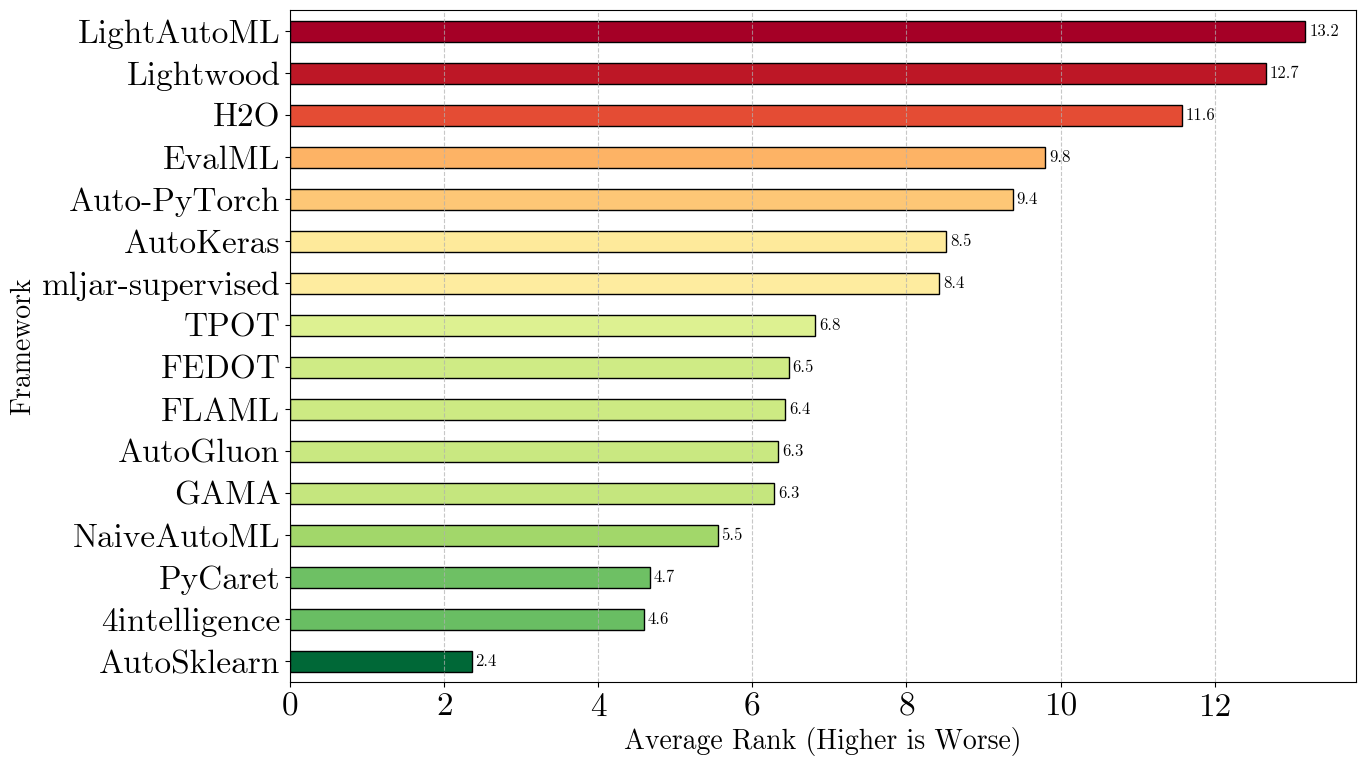

In [23]:
plot_average_ranks(
    res_f1['avg_ranks'],
    "Frameworks Average Ranks across Datasets (F1 Score)",
    save_path=f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_avg_ranks_f1.png"
)

✅ Using Friedman posthoc matrix (Nemenyi test). No correction applied.


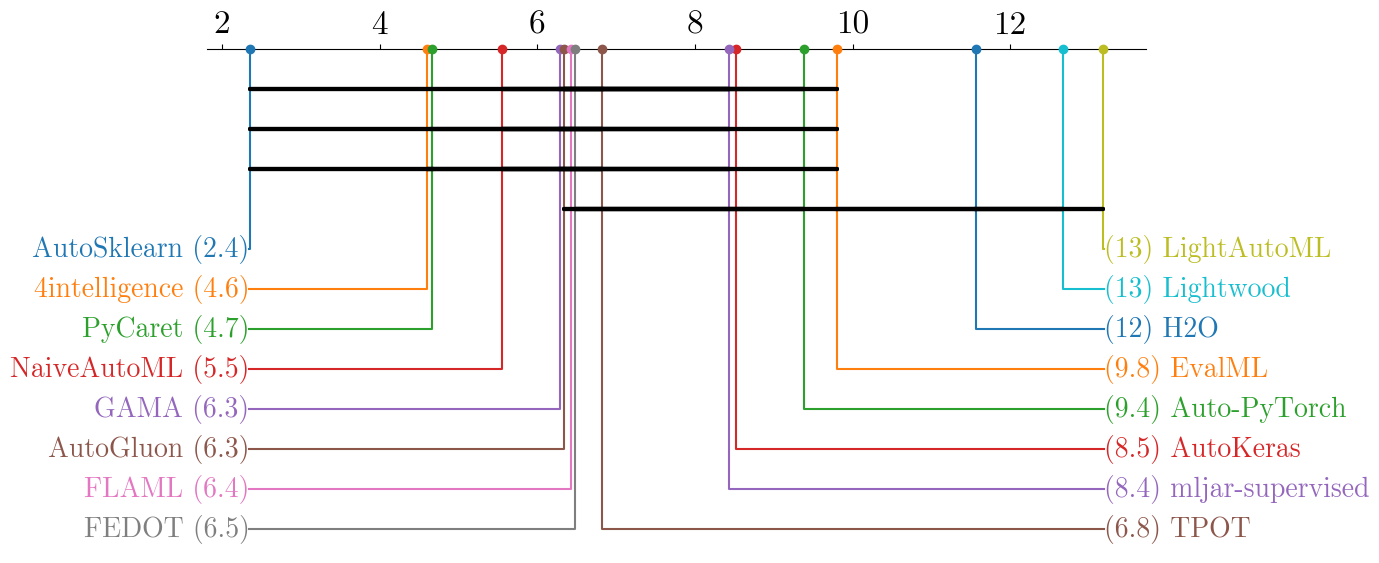

✅ Critical Difference Diagram saved to: stats/all/all_step_3b_across_datasets_cd_diagram_f1.png


In [24]:
plot_cd_diagram(
    res_dict=res_f1,
    save_path = f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_cd_diagram_f1.png"
)

In [25]:
res_time = across_datasets_analysis(df, metric_col='training_time', agg_func='median')

print("\nTime Analysis:")
for k, v in res_time.items():
    print_formatted_result(k, v)

📊 NaN Count Before Sphericity Check:
 subject    0
within     0
dv         0
dtype: int64
🔬 Normality Test (Shapiro-Wilk) - p-value: 1.1652771635446948e-22
🔬 Sphericity Test - W: 3.414924786876172, χ²(119) = 4896.827500806401, p-value: 0.0
⚠️ Normality assumption violated → Using Friedman test.
✅ Friedman test completed: p-value = 1.7613856239370238e-29
✅ Friedman p-value: 1.7613856239370238e-29
✅ Significant differences detected → Selecting between Nemenyi and Conover
✅ Using **Nemenyi** test (Comparisons: 120), Correction: None
✅ Final Method Used: Friedman + Nemenyi + No Correction

Time Analysis:
  normality_test: Shapiro-Wilk
  normality_p: 1.1652771635446948e-22
  sphericity_p: 0.0
  spherical?: False
  parametric: False
  method: Friedman + Nemenyi
  anova_result: None
  anova_p: None
  friedman_stat: 175.68277310924373
  friedman_p: 1.7613856239370238e-29
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,2.419772e-04,2.729563e-04,5.997252e-02,0.999998,5.054806e-01,9.999998e-01,1.000000e+00,0.999893,6.084361e-01,0.702650,1.001714e-07,3.403603e-03,0.791702,2.438828e-01,3.573582e-01
autogluon,2.419772e-04,1.000000e+00,1.000000e+00,6.150636e-14,0.005458,7.470879e-11,1.147216e-05,1.678945e-04,0.014469,1.987450e-10,0.436027,9.914446e-01,9.999998e-01,0.341982,8.782329e-01,1.640554e-11
autokeras,2.729563e-04,1.000000e+00,1.000000e+00,7.549517e-14,0.006032,8.967005e-11,1.314560e-05,1.897776e-04,0.015859,2.377573e-10,0.454445,9.897714e-01,9.999999e-01,0.358691,8.891922e-01,1.978995e-11
autopytorch,5.997252e-02,6.150636e-14,7.549517e-14,1.000000e+00,0.004812,9.999390e-01,2.820606e-01,7.530358e-02,0.001659,9.996607e-01,0.000003,1.110223e-16,6.460721e-12,0.000007,6.241034e-08,9.999979e-01
autosklearn,9.999981e-01,5.458211e-03,6.031851e-03,4.811969e-03,1.000000,1.115372e-01,9.962142e-01,9.999927e-01,1.000000,1.595064e-01,0.983743,6.438595e-06,4.595374e-02,0.993681,7.373850e-01,6.135843e-02
evalml,5.054806e-01,7.470879e-11,8.967005e-11,9.999390e-01,0.111537,1.000000e+00,8.921890e-01,5.627194e-01,0.052723,1.000000e+00,0.000377,9.992007e-16,4.633913e-09,0.000706,1.366269e-05,1.000000e+00
fedot,9.999998e-01,1.147216e-05,1.314560e-05,2.820606e-01,0.996214,8.921890e-01,1.000000e+00,1.000000e+00,0.977220,9.393856e-01,0.278350,2.055583e-09,2.366488e-04,0.364048,4.856937e-02,7.856469e-01
flaml,1.000000e+00,1.678945e-04,1.897776e-04,7.530358e-02,0.999993,5.627194e-01,1.000000e+00,1.000000e+00,0.999728,6.644633e-01,0.648178,6.241034e-08,2.483705e-03,0.743689,2.053348e-01,4.095723e-01
gama,9.998932e-01,1.446891e-02,1.585908e-02,1.659349e-03,1.000000,5.272269e-02,9.772196e-01,9.997275e-01,1.000000,7.960563e-02,0.997633,2.549530e-05,9.886951e-02,0.999366,8.810333e-01,2.683052e-02
h2o,6.084361e-01,1.987450e-10,2.377573e-10,9.996607e-01,0.159506,1.000000e+00,9.393856e-01,6.644633e-01,0.079606,1.000000e+00,0.000707,3.330669e-15,1.140416e-08,0.001296,2.815701e-05,1.000000e+00


  avg_ranks:


,avg_rank
framework,
lightwood,1.333333
autogluon,3.111111
autokeras,3.142857
mljar,3.857143
pycaret,5.523810
lightautoml,6.352941
naive,6.523810
gama,7.928571
autosklearn,8.250000


In [26]:
undesired_columns = ['anova_result', 'posthoc', 'avg_ranks']

res_time_df = simplify_statistical_results(res_time).drop(columns=undesired_columns, errors="ignore")

res_time_df.to_csv(f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_stat_results_time.csv")

res_time_df

,normality_test,normality_p,normal?,sphericity_test,sphericity_p,spherical?,sphericity_correction,parametric,method,p_value,significant
scenario,,,,,,,,,,,
all,Shapiro-Wilk,1.2e-22,False,Mauchly’s Test,0.0e+00,False,None,False,Friedman + Nemenyi,1.8e-29,True


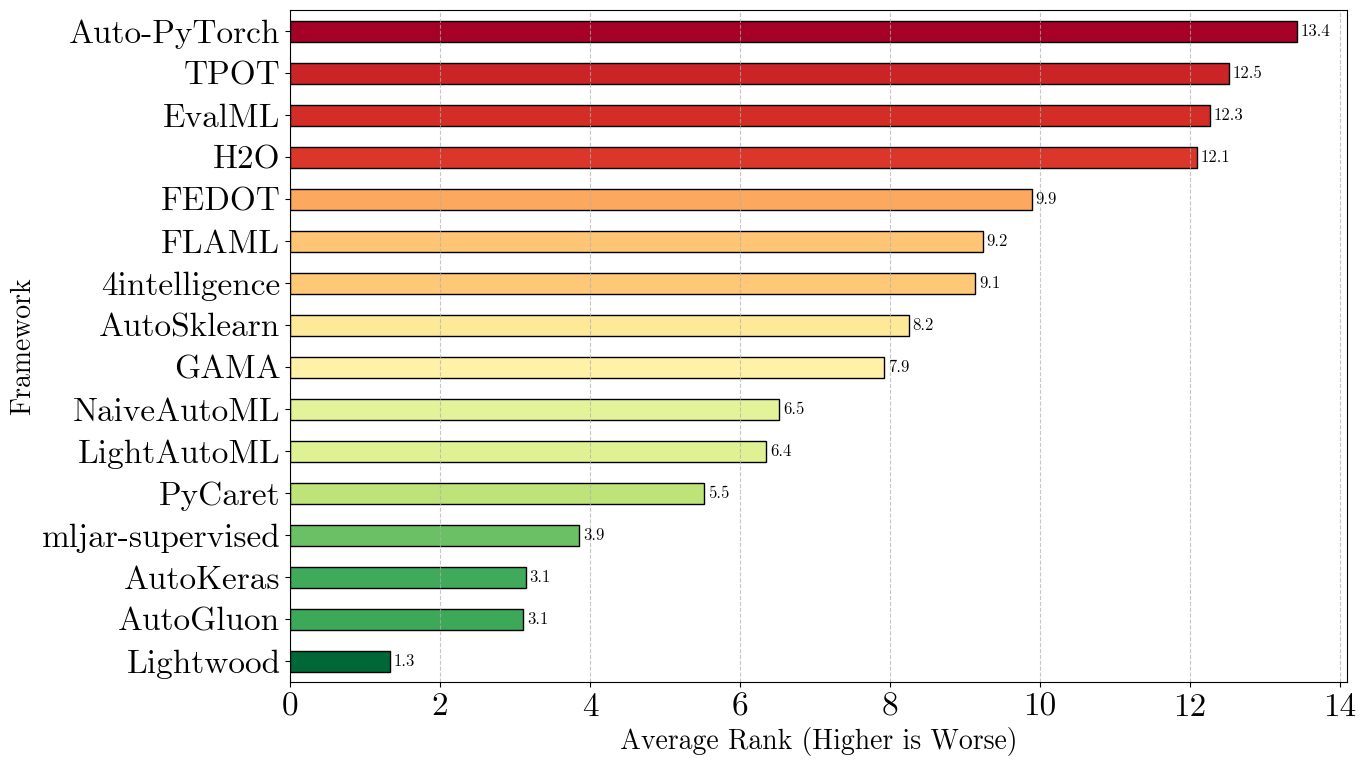

In [27]:
plot_average_ranks(
    res_time['avg_ranks'],
    "Frameworks Average Ranks across Datasets (Training Time)",
    save_path=f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_avg_ranks_time.png"
)

✅ Using Friedman posthoc matrix (Nemenyi test). No correction applied.


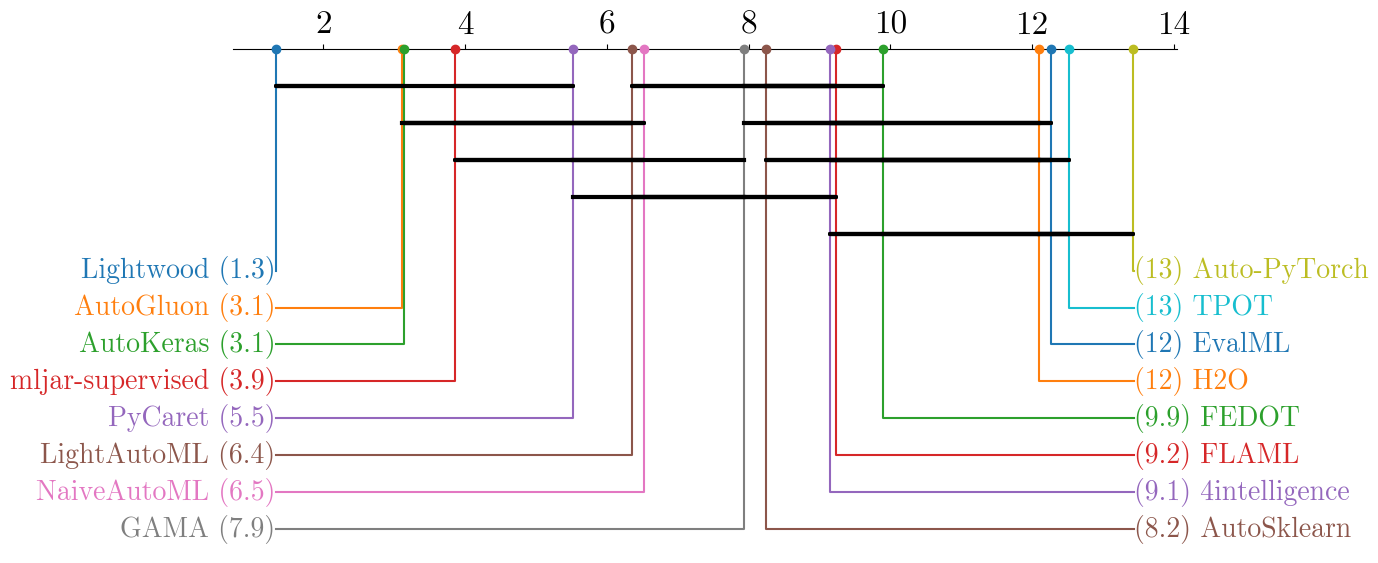

✅ Critical Difference Diagram saved to: stats/all/all_step_3b_across_datasets_cd_diagram_time.png


In [28]:
plot_cd_diagram(
    res_dict=res_time,
    save_path = f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_cd_diagram_time.png"
)

In [29]:
# Suppose you already computed avg_ranks_f1 and avg_ranks_time as Pandas Series:
#   - Index = framework name
#   - Values = average rank
# Combine them
df_ranks = pd.DataFrame({
    'Framework': res_f1['avg_ranks'].index,
    'Rank_F1': res_f1['avg_ranks'].values,
    'Rank_Time': res_time['avg_ranks'][res_f1['avg_ranks'].index].values  # align same frameworks
})

# Sort optionally by Rank_F1
df_ranks.sort_values(by='Rank_F1', inplace=True)

# Display the table
df_ranks.to_csv(f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_dual_ranks.csv")
df_ranks

,Framework,Rank_F1,Rank_Time
0,autosklearn,2.357143,8.250000
1,4intelligence,4.595238,9.142857
2,pycaret,4.666667,5.523810
3,naive,5.547619,6.523810
4,gama,6.285714,7.928571
5,autogluon,6.333333,3.111111
6,flaml,6.428571,9.238095
7,fedot,6.473684,9.894737
8,tpot,6.815789,12.526316
9,mljar,8.428571,3.857143


In [30]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_dual_ranks(df_ranks, save_path, mark=True, invert=(False, False)):
    """
    Plots a scatter plot of frameworks' average ranks in F1 score vs. training time.

    Parameters:
    - df_ranks (pd.DataFrame): DataFrame containing 'Framework', 'Rank_F1', and 'Rank_Time'.
    - save_path (str): Path to save the generated figure.
    - mark (bool): If True, highlights the best framework (lowest rank in both metrics).
    - invert (tuple): (invert_x, invert_y), where True means the axis is inverted.
    """
    if df_ranks is None or df_ranks.empty:
        print("⚠️ No data to plot.")
        return

    # 🚀 Create a copy to avoid modifying the original DataFrame
    df_ranks_copy = df_ranks.copy()

    # 🚀 Apply framework name mapping
    df_ranks_copy['Framework'] = df_ranks_copy['Framework'].map(lambda x: framework_mapping.get(x, x))

    # 🚀 Identify the best framework (lowest rank in both metrics)
    if mark:
        best_framework = df_ranks_copy.loc[
            df_ranks_copy[['Rank_F1', 'Rank_Time']].sum(axis=1).idxmin()
        ]
        best_x, best_y, best_name = best_framework['Rank_F1'], best_framework['Rank_Time'], best_framework['Framework']
    else:
        best_x, best_y, best_name = None, None, None

    # 🚀 Plot scatter plot
    plt.figure(figsize=global_fig_size_wide)
    plt.scatter(df_ranks_copy['Rank_F1'], df_ranks_copy['Rank_Time'], color='blue', label="Frameworks", s=50)

    # 🚀 Mark the best framework (if enabled)
    if mark:
        plt.scatter(best_x, best_y, color='red', edgecolors='black', s=100, zorder=3, label="Best Framework")
    
    # 🚀 Create text labels
    texts = []
    for _, row in df_ranks_copy.iterrows():
        text = plt.text(
            row['Rank_F1'], row['Rank_Time'], row['Framework'], 
            ha='center', va='center', fontsize=15
        )
        texts.append(text)

    # 🚀 Automatically adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    # 🚀 Labels & Titles
    plt.xlabel(r"Average Rank ($F_1$ Score) - lower is better")
    plt.ylabel("Average Rank (Training Time) - lower is better")

    # 🚀 Apply axis inversion if needed
    if invert[0]:
        plt.gca().invert_xaxis()
    if invert[1]:
        plt.gca().invert_yaxis()

    # 🚀 Grid & Layout
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()

    # 🚀 Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 🚀 Save and show the plot
    plt.savefig(save_path, dpi=global_dpi)
    plt.show()

    print(f"✅ Dual rank scatter plot saved to: {save_path}")

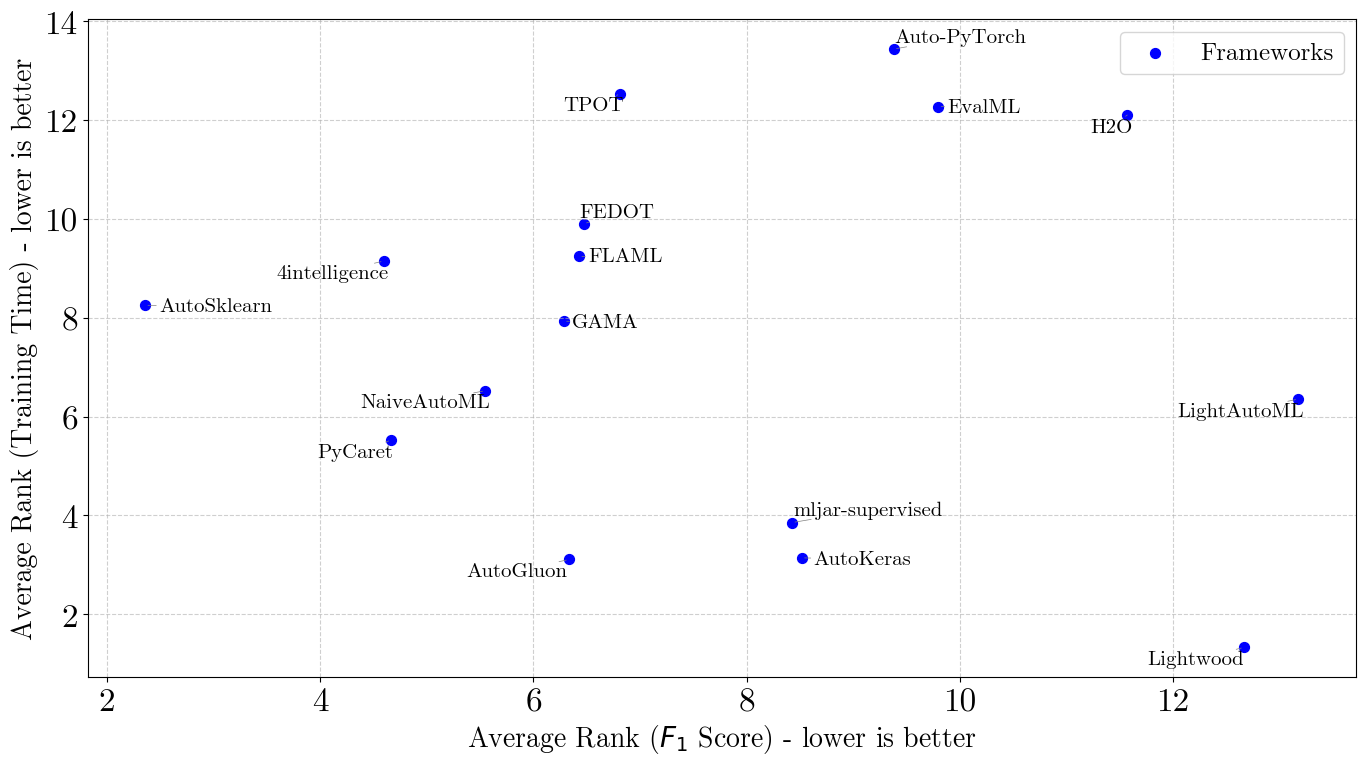

✅ Dual rank scatter plot saved to: stats/all/all_step_3b_across_datasets_dual_ranks_clean.png


In [31]:
plot_dual_ranks(
    df_ranks,
    save_path=f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_dual_ranks_clean.png",
    mark=False,
    invert=(False, False)
)

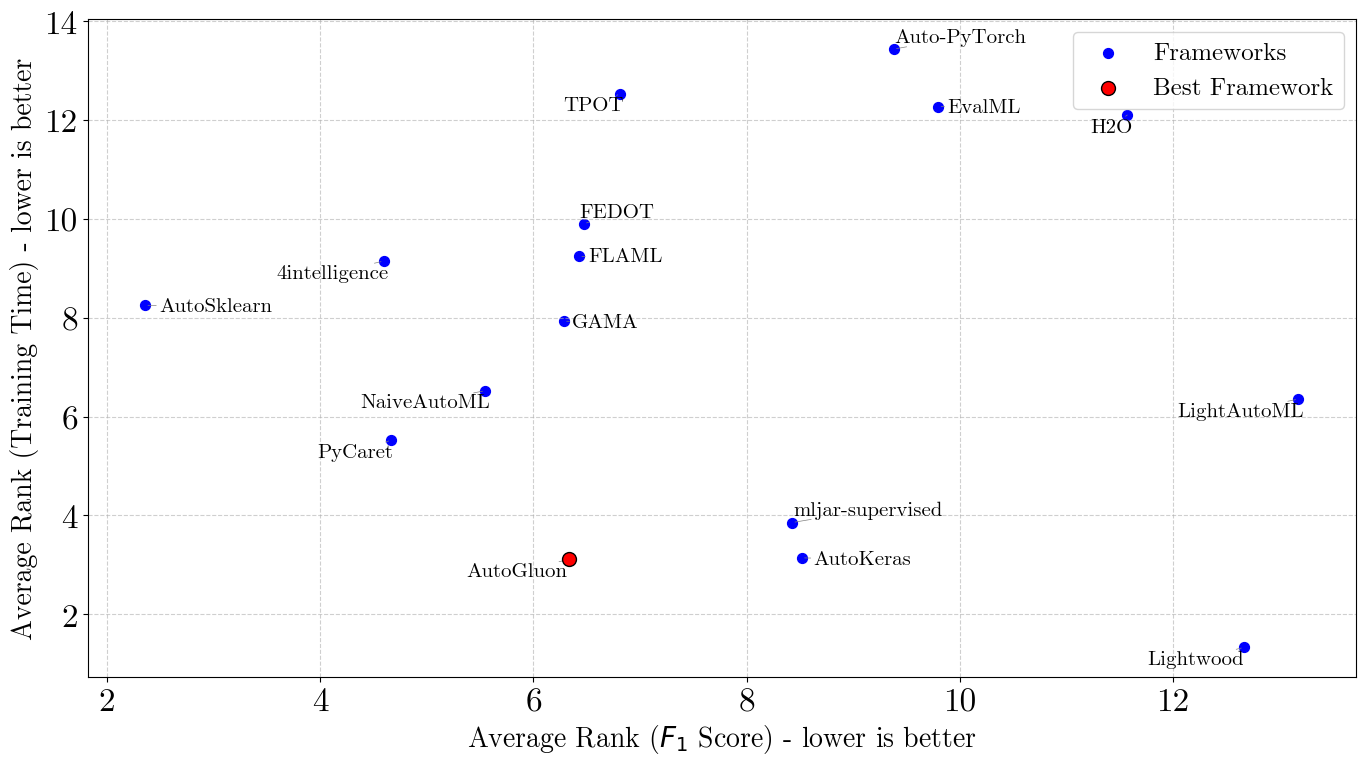

✅ Dual rank scatter plot saved to: stats/all/all_step_3b_across_datasets_dual_ranks_marked.png


In [32]:
plot_dual_ranks(
    df_ranks,
    save_path=f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_dual_ranks_marked.png",
    mark=True,
    invert=(False, False)
)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
from adjustText import adjust_text
from matplotlib import cm
from matplotlib.colors import Normalize

def pad_right(text):
    new_text = text
    if 'Light' in text:
        new_text += ' '
    return new_text

def plot_dual_ranks_with_color_scale(df_ranks, save_path, invert=(False, False)):
    """
    Plots a scatter plot of frameworks' average ranks in F1 score vs. training time,
    with colors ranging from red (worst) to green (best) based on the sum of ranks.

    Parameters:
    - df_ranks (pd.DataFrame): DataFrame containing 'Framework', 'Rank_F1', and 'Rank_Time'.
    - save_path (str): Path to save the generated figure.
    - invert (tuple): (invert_x, invert_y), where True means the axis is inverted.
    """
    if df_ranks is None or df_ranks.empty:
        print("⚠️ No data to plot.")
        return

    # 🚀 Create a copy to avoid modifying the original DataFrame
    df_ranks_copy = df_ranks.copy()

    # 🚀 Apply framework name mapping (if needed)
    df_ranks_copy['Framework'] = df_ranks_copy['Framework'].map(lambda x: framework_mapping.get(x, x))

    # 🚀 Compute the sum of ranks (used for coloring)
    df_ranks_copy["Total_Rank"] = df_ranks_copy["Rank_F1"] + df_ranks_copy["Rank_Time"]

    # 🚀 Identify the best framework (lowest sum of ranks)
    best_idx = df_ranks_copy["Total_Rank"].idxmin()
    best_framework = df_ranks_copy.loc[best_idx]
    best_x, best_y, best_name = best_framework["Rank_F1"], best_framework["Rank_Time"], best_framework["Framework"]

    # 🚀 Exclude the best framework from the main scatter plot
    df_other = df_ranks_copy.drop(index=best_idx)

    # 🚀 Normalize the rank values for colormap scaling
    norm = Normalize(
        vmin=df_ranks_copy["Total_Rank"].min(),
        vmax=df_ranks_copy["Total_Rank"].max()
    )
    colors = cm.RdYlGn_r(norm(df_other["Total_Rank"]))  # Red (worst) → Green (best)

    # 🚀 Plot scatter plot for all frameworks except the best one
    plt.figure(figsize=global_fig_size_wide)
    scatter = plt.scatter(df_other["Rank_F1"], df_other["Rank_Time"], 
                          c=df_other["Total_Rank"], cmap='RdYlGn_r', edgecolors='black', s=100)

    # 🚀 Mark the best framework with a star in its correct color
    best_color = cm.RdYlGn_r(norm(best_framework["Total_Rank"]))  # Assign correct color
    plt.scatter(best_x, best_y, c=[best_color], s=250, marker='*', edgecolors='black', zorder=3, label="Best Framework")

    # 🚀 Create text labels
    texts = []
    for _, row in df_ranks_copy.iterrows():
        text = plt.text(
            row["Rank_F1"] + 0.05,   # a small positive shift to the right
            row["Rank_Time"] + 0.05, # a small positive shift upward
            pad_right(row["Framework"]), 
            ha="left", va="bottom", fontsize=15
        )
        print(text)
        texts.append(text)

    # 🚀 Automatically adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

    # 🚀 Labels & Titles
    plt.xlabel(r"Average Rank ($F_1$ Score) - lower is better")
    plt.ylabel("Average Rank (Training Time) - lower is better")

    # 🚀 Apply axis inversion if needed
    if invert[0]:
        plt.gca().invert_xaxis()
    if invert[1]:
        plt.gca().invert_yaxis()

    # 🚀 Grid & Layout
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()  # Ensure the legend appears correctly
    plt.colorbar(scatter, label="Total Rank (Lower is Better)")
    plt.tight_layout()

    # 🚀 Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 🚀 Save and show the plot
    plt.savefig(save_path, dpi=global_dpi)
    plt.show()

    print(f"✅ Dual rank scatter plot saved to: {save_path}")

Text(2.407142857142857, 8.3, 'AutoSklearn')
Text(4.645238095238095, 9.192857142857143, '4intelligence')
Text(4.716666666666667, 5.5738095238095235, 'PyCaret')
Text(5.597619047619047, 6.5738095238095235, 'NaiveAutoML')
Text(6.335714285714285, 7.978571428571429, 'GAMA')
Text(6.383333333333333, 3.161111111111111, 'AutoGluon')
Text(6.478571428571429, 9.288095238095238, 'FLAML')
Text(6.523684210526316, 9.944736842105264, 'FEDOT')
Text(6.86578947368421, 12.576315789473686, 'TPOT')
Text(8.47857142857143, 3.907142857142857, 'mljar-supervised')
Text(8.567857142857143, 3.1928571428571426, 'AutoKeras')
Text(9.430952380952382, 13.47857142857143, 'Auto-PyTorch')
Text(9.850000000000001, 12.316666666666668, 'EvalML')
Text(11.621428571428572, 12.145238095238096, 'H2O')
Text(12.716666666666667, 1.3833333333333333, 'Lightwood ')
Text(13.226470588235294, 6.402941176470588, 'LightAutoML ')


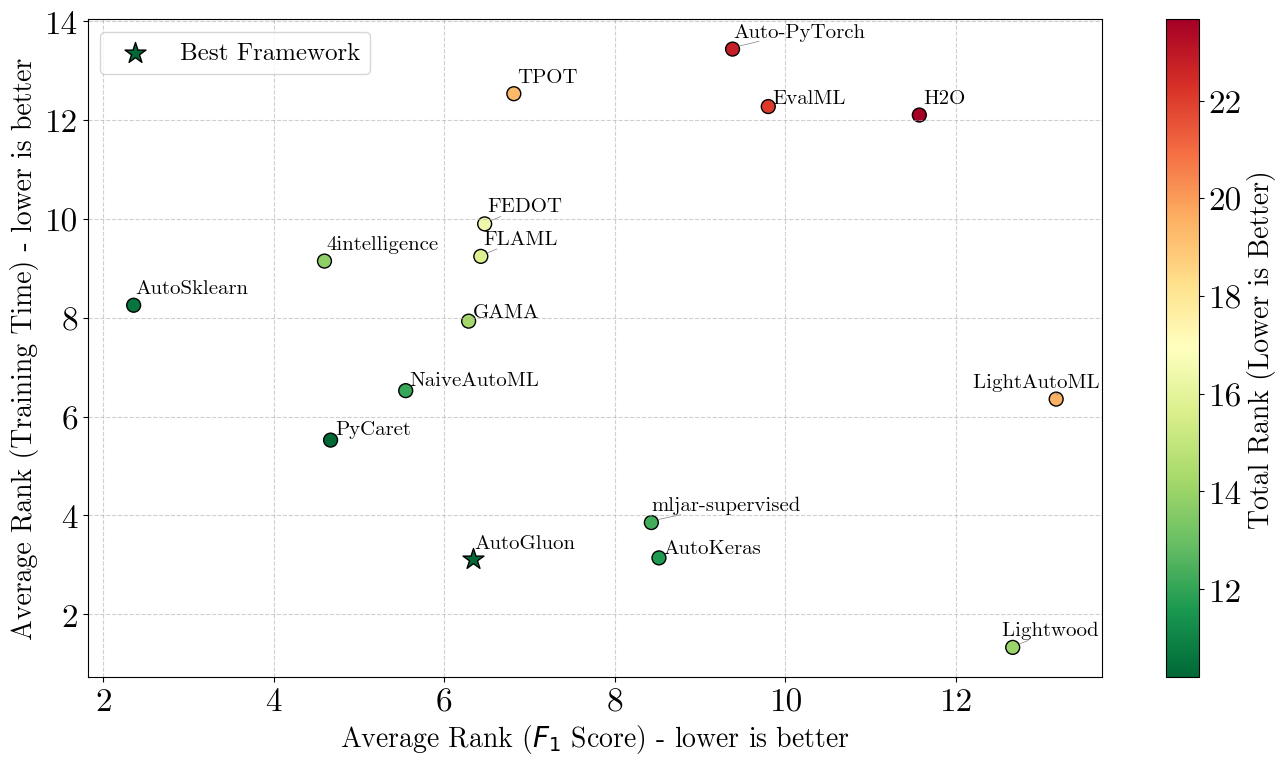

✅ Dual rank scatter plot saved to: stats/all/all_step_3b_across_datasets_dual_ranks_colored.png


In [34]:
plot_dual_ranks_with_color_scale(
    df_ranks,
    save_path=f"stats/{scenario}/{scenario}_step_{step_id}_across_datasets_dual_ranks_colored.png",
    invert=(False, False)
)